Handling TensorFlow graphs and sessions
--

##### Check [How GPflow relates to TensorFlow: tips & tricks](../tips_and_tricks.ipynb) for more examples and information.

In [4]:
import gpflow
import tensorflow as tf


TensorFlow gives you a default graph, which you fill with tensors and operations - nodes and edges in the graph respectively. See the [TensorFlow documentation on building a `tf.Graph`](https://www.tensorflow.org/guide/graphs#building_a_tfgraph) for details on how to change the default graph or exploit multiple graphs.

A TensorFlow graph is a representation of your computation. To execute your code you need a [TensorFlow session](https://www.tensorflow.org/guide/graphs#executing_a_graph_in_a_tfsession). For example, you can think of graphs and sessions as binary sources and actual command running it in  a terminal. Normally, TensorFlow doesn't provide the default session; however, GPflow creates a default session that you can access as shown in the following example:

In [5]:
session = gpflow.get_default_session()

To change GPflow's default session:

In [6]:
gpflow.reset_default_session()
assert session is not gpflow.get_default_session()

You can manipulate sessions manually, but you have to make them the default for GPflow:

In [7]:
with tf.Session() as session:
    k = gpflow.kernels.SquaredExponential(input_dim=1)
    k.lengthscales = 2.0
    k.variance = 3.0

W0816 11:52:23.051765 140208876939072 deprecation_wrapper.py:119] From /home/alexandra/virtual_environments/prowler_venv/lib/python3.6/site-packages/gpflow/core/node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 11:52:23.058769 140208876939072 deprecation_wrapper.py:119] From /home/alexandra/virtual_environments/prowler_venv/lib/python3.6/site-packages/gpflow/params/parameter.py:388: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Now, TensorFlow variables and tensors for the created `SquaredExponential` kernel are initialised with the session that was closed when the Python context ended. You can re-use the `SquaredExponential` object by re-initialising it.

In [8]:
k.initialize(gpflow.get_default_session())
k

,class,prior,transform,trainable,shape,fixed_shape,value
SquaredExponential/lengthscales,Parameter,None,+ve,True,(),True,2.0
SquaredExponential/variance,Parameter,None,+ve,True,(),True,3.0


## Using feed dicts with autoflow

We'll recreate something like Figure 5.5 from [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf), which is a plot of the marginal likelihood against hyperparameter configurations. We want to loop over a grid of hyperparameters, but GPflow can be very slow to do this using the assign method. We can get around this by using a feed dict with autoflow. 


In [9]:
import numpy as np
X = np.array((-6, -4, -2.1, -2, 2, 5.5, 6)).reshape(-1, 1)
Y = np.array((-0.5, -0.5, 1.7, 1.6, 1, 2, 1.9)).reshape(-1, 1)

model = gpflow.models.GPR(X, Y, gpflow.kernels.RBF(1))

In [10]:
%%timeit
# this is how long it takes to do the calculation with fixed parameters
model.compute_log_likelihood()
pass

1.67 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
# the assign method
model.kern.lengthscales = 1.
model.likelihood.variance = 0.1
model.compute_log_likelihood()

2.08 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
def make_feed(param, value):
    return {param.unconstrained_tensor : param.transform.backward(value)}

In [10]:
%%timeit
# the feed dict method
feed_dict = {}
feed_dict.update(make_feed(model.kern.lengthscales, 1.))
feed_dict.update(make_feed(model.likelihood.variance, 0.1))
model.compute_log_likelihood(feed_dict=feed_dict)

1.07 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
def evaluate(func, param_feed_dict):
    tensor_feed_dict = {}
    for param, value in param_feed_dict.items():
        tensor_feed_dict.update(make_feed(param, value))
    return func(feed_dict=tensor_feed_dict)

In [12]:
%%timeit
evaluate(model.compute_log_likelihood, {model.kern.lengthscales: 1., model.likelihood.variance: 0.1})

1.08 ms ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


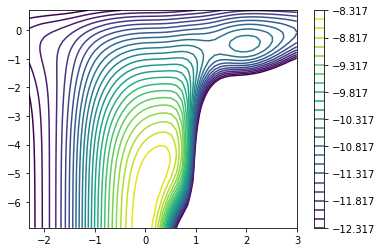

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# with the feed dict method this example is feasible

log_noises = np.linspace(np.log(0.001), np.log(2.), 50)
log_lengthscales = np.linspace(np.log(0.1), np.log(20), 50)

xx, yy = np.meshgrid(log_lengthscales, log_noises)
zz = []

for lengthscale, noise in zip(np.exp(xx.flatten()), np.exp(yy.flatten())):
    feed_dict = {}
    feed_dict.update(make_feed(model.kern.lengthscales, lengthscale))
    feed_dict.update(make_feed(model.likelihood.variance, noise))
    # adapt GPflow so that we can use the following instead:
    #zz.append(model.evaluate(model.compute_log_likelihood,
    #                         {model.kern.lengthscales: lengthscale,
    #                          model.likelihood.variance: noise}
    #                        ))
    # to pass arguments e.g. for predict_f(XX), could use
    # model.evaluate(functools.partial(model.predict_f, XX), {...: ..., ...})
    zz.append(model.compute_log_likelihood(feed_dict=feed_dict))
    
plt.contour(xx, yy, np.array(zz).reshape(xx.shape),
           levels = np.linspace(np.max(zz)-4, np.max(zz), 25))
plt.colorbar()
plt.show()